In [1]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import sys
sys.path.append('../../../')
from utils import *

## Prepro: change names to numbers

In [2]:
train_feats = pd.read_csv('../../../feature_eng/train_452feats.csv')
train_score = pd.read_csv('../../../data/train_scores.csv')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

## Keep columns

In [3]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat"

endings_to_keep = ["-time_gaps", "-paragraph_ratios"]
endings_to_keep += ["id"]

dir_to_save = "lgb0"

cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

51


In [4]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

In [5]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [6]:
def objective(trial,train_x,train_y,val_x,val_y,RANDOM_STATE=41):

    params = {
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-4, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.4,0.7,1.0]),
        'colsample_bynode': trial.suggest_categorical('colsample_bynode', [0.4,0.7,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.7,1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True), #trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [9,11,13,15,17,20]),
        'min_child_samples': trial.suggest_categorical('min_child_samples', [7,9,11,13,15,17,20]),
        'num_leaves': trial.suggest_int('num_leaves', 10, 38, step=4),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1900, step=200),
    }

    all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -2,
        **params
    }

    model = lgb.LGBMRegressor(**all_params)
    
    model.fit(train_x, train_y)#, eval_set=[(val_x, val_y)], #verbose=False,
    
    preds = model.predict(val_x)
    
    rmse = mean_squared_error(val_y, preds, squared=False)
    
    return rmse

In [7]:
def lgb_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, save=False):
    # split into two validations
    x_valid1, x_valid2, y_valid1, y_valid2 = train_test_split(x_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE, shuffle=False)

    '''Use v1, test on v2'''

    # Bayesian Opt using v1
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid1, y_valid1,RANDOM_STATE), n_trials=20)
    best_trial1 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -2,
        **best_trial1
    }
        
    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_train, y_train)
    if save:
        model.booster_.save_model(f'./{dir_to_save}/lgb_iter{iter}_split{split}_val1.txt')

    # Predict on v2
    valid2_predict = model.predict(x_valid2)


    '''Use v2, test on v1'''

    # Bayesian Opt using v2
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid2, y_valid2,RANDOM_STATE), n_trials=20)
    best_trial2 = study.best_trial.params

    # Get best params
    best_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -2,
        **best_trial2
    }
        
    model = lgb.LGBMRegressor(**best_params)
    model.fit(x_train, y_train)
    if save:
        model.booster_.save_model(f'./{dir_to_save}/lgb_iter{iter}_split{split}_val2.txt')

    # Predict on v1
    valid1_predict = model.predict(x_valid1)

    # Return OOFs
    return np.concatenate([valid1_predict,valid2_predict])

In [8]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1

iterations = 5
n_splits = 4

for i in range(iterations):

    kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
    j = 0
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        valid_predict = lgb_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i, save=True)

        OOF_SCORE[valid_idx] += valid_predict / iterations
        j+=1

[I 2023-12-27 23:01:40,952] A new study created in memory with name: no-name-461a240f-39b1-4c26-ad20-16146f65891d
[I 2023-12-27 23:01:42,974] Trial 0 finished with value: 0.8152651857682768 and parameters: {'reg_lambda': 7.262438472172396, 'reg_alpha': 1.0216998776343449, 'colsample_bytree': 0.7, 'colsample_bynode': 1.0, 'subsample': 0.7, 'learning_rate': 0.00022530142237462265, 'max_depth': 9, 'min_child_samples': 7, 'num_leaves': 18, 'n_estimators': 1900}. Best is trial 0 with value: 0.8152651857682768.
[I 2023-12-27 23:01:45,141] Trial 1 finished with value: 0.6711082233168267 and parameters: {'reg_lambda': 0.011435853993204625, 'reg_alpha': 0.003419091126652897, 'colsample_bytree': 0.4, 'colsample_bynode': 0.4, 'subsample': 1.0, 'learning_rate': 0.0015820046952891148, 'max_depth': 20, 'min_child_samples': 7, 'num_leaves': 22, 'n_estimators': 1900}. Best is trial 1 with value: 0.6711082233168267.
[I 2023-12-27 23:01:46,374] Trial 2 finished with value: 0.6855862610169654 and paramet

In [9]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric LGBM = 0.66146


In [10]:
import pickle

with open(f'{dir_to_save}/OOF_base_lgb.pkl', 'wb') as f:
    pickle.dump(OOF_SCORE, f)

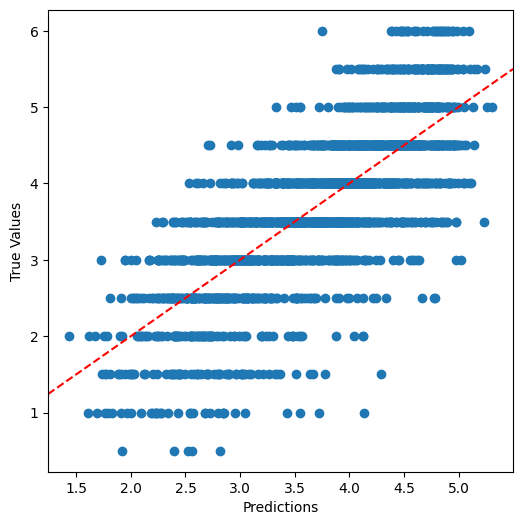

In [11]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()